# Реализация метода CLIP + Multibead Attention

Цель: Классифицировать каждую секунду видео как "интро/титры" (1) или "основной контент" (0)
1. **Преобразуем видео в последовательность секунд**
   Видео уже порезано до 1 кадра в секунду (1 FPS)—это оптимальный компромисс по точности и скорости .

   > 1 кадр = 1 секунда времени. Длина эпизода в секундах = число кадров папки.

2. **Формируем скользящие окна по 60 кадров**
   *Окно* длиной ровно 1 мин. прокатываем по всей серии без пропусков:

   ```
   кадры 0-59, 1-60, 2-61, …  
   ```

   Такое «окно» даёт модели вид сразу на минуту истории и подходящее число параметров .

3. **Извлекаем признаки CLIP для каждого кадра**
   Каждый кадр 224×224 пропускаем через изображ-ный энкодер CLIP-ViT-B/32 и получаем вектор `f_t` размерности 512 .
   Для 60 кадров окна складывается матрица `(60 × 512)`.

4. **Добавляем обучаемые позиционные эмбеддинги**
   Чтобы модель «знала», какой кадр раньше/позже, к каждому вектору `f_t` прибавляем свой маленький вектор `P_t` (учится вместе с моделью) .

5. **Прогоняем окно через 16-слойный блок Multi-Head Attention**
   16 слоёв × 16 голов—эта глубина показала максимум F1 без переобучения .
   Attention позволяет «видеть» долгие зависимости: например, титры длятся десятки кадров.

6. **Классифицируем каждый кадр независимо**
   На выходе - 60 однонейронных «голов» (линейные слои) с сигмоидой, каждая говорит:

   ```
   ŷ_t  ≈ 1  -> кадр = интро/титры  
   ŷ_t  ≈ 0  -> кадр = основное содержание
   ```

7. **Обучаемся по бинарной кросс-энтропии**
   Потеря считается по каждому кадру окна .
   *Гиперпараметры из статьи*: Adam, `lr = 5e-5`, `batch_size = 8`, seed `42`.

8. **Получаем таймкоды**

   * **Конец интро** = последняя подряд секунда, где `p(t) > thr_start` (порог 0 .6).
   * **Начало титров** = первая секунда с `p(t) > thr_end` (порог 0 .55) ближе к концу серии.
     Те же пороги использовались авторами (видно на графике)

<img src="arcitecture.png" alt="architecture" width="1000"/>

9. **Метрики**
   *Кадровые*: Accuracy, Precision, Recall, F1.
   *Граничные*: абсолютная ошибка (сек) начала/конца.

10. **Визуализация**
    Строим график `p(t)` + горизонтальные пороги + вертикальные линии, как на вашем примере.

### Импорт и базовые настройки

In [2]:
import warnings, os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # глушим низкоуровневые логи TF
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning,
                        module="transformers.image_processing_utils")
import re
import pandas as pd
import numpy as np
import torch
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel

torch.manual_seed(42)
np.random.seed(42)
num = np.random.randint(0, 1000)
# Конфигурация
DATA_ROOT = Path('.')
FRAMES_DIR = DATA_ROOT / 'data' / 'frames'
AUDIO_DIR = DATA_ROOT / 'data' / 'audio'
CLIP_DIR = DATA_ROOT / 'data' / 'clip_features'  # Новая папка для CLIP-фичей
LABELS_PATH = DATA_ROOT / 'data' / 'labels.csv'
MODEL_SAVE_PATH = f"models/clip_transformer_model_{num}.pth"

# Создаем папки
CLIP_DIR.mkdir(parents=True, exist_ok=True)

# Гиперпараметры
WINDOW_SIZE = 60
BATCH_SIZE = 8
LR = 5e-5
EPOCHS = 10

# Определение устройства
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Загрузка CLIP модель
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained(
    "openai/clip-vit-base-patch32"
)
clip_model = clip_model.to(device).eval()


def time_to_seconds(time_str):
    """Конвертирует время в формате HH:MM:SS в секунды"""
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)


# Загрузка разметки
labels_df = pd.read_csv(LABELS_PATH)

# Преобразуем временные метки в секунды
labels_df['start_sec'] = labels_df['start_main'].apply(time_to_seconds)
labels_df['end_sec'] = labels_df['end_main'].apply(time_to_seconds)

# Извлекаем название шоу и эпизода
labels_df['show'] = labels_df['file'].apply(lambda x: x.split('/')[0])
labels_df['episode_name'] = labels_df['file'].apply(
    lambda x: os.path.splitext(os.path.basename(x))[0]
)

Using device: cpu


### Загрузка и предобработка данных

In [9]:
import torch.nn as nn
# Функция для проверки полноты CLIP-фичей
def check_clip_features_complete(show, episode_name):
    """Проверяет, все ли CLIP-фичи для эпизода уже извлечены"""
    frames_dir = FRAMES_DIR / show / episode_name
    clip_dir = CLIP_DIR / show / episode_name

    if not frames_dir.exists() or not clip_dir.exists():
        return False

    frame_files = set(f.stem for f in frames_dir.glob('*.jpg'))
    clip_files = set(f.stem for f in clip_dir.glob('*.npy'))

    return frame_files == clip_files


# Функция для извлечения отсутствующих CLIP-фичей
def extract_missing_clip_features():
    """Извлекает только отсутствующие CLIP-фичи"""
    for idx, row in tqdm(labels_df.iterrows(), total=len(labels_df), desc="Checking CLIP features"):
        show = row['show']
        episode_name = row['episode_name']
        frames_dir = FRAMES_DIR / show / episode_name

        if not frames_dir.exists():
            print(f"Папка с фреймами не найдена: {frames_dir}")
            continue

        # Проверяем, все ли фичи уже извлечены
        if check_clip_features_complete(show, episode_name):
            continue

        # Папка для сохранения CLIP-фичей
        clip_episode_dir = CLIP_DIR / show / episode_name
        clip_episode_dir.mkdir(parents=True, exist_ok=True)

        # Обрабатываем каждый кадр
        for frame_path in sorted(frames_dir.glob('*.jpg'), key=lambda x: int(x.stem)):
            clip_path = clip_episode_dir / f"{frame_path.stem}.npy"

            # Пропускаем уже существующие фичи
            if clip_path.exists():
                continue

            try:
                img = Image.open(frame_path).convert('RGB')
                inputs = clip_processor(images=img, return_tensors="pt").to(device)

                with torch.no_grad():
                    outputs = clip_model.get_image_features(**inputs)

                # Сохраняем фичи
                features = outputs.cpu().numpy()
                np.save(clip_path, features)

            except Exception as e:
                print(f"Ошибка обработки {frame_path}: {e}")
                # Создаем нулевой вектор в случае ошибки
                np.save(clip_path, np.zeros((1, 512)))


# Вызываем функцию для извлечения отсутствующих фичей
print("Проверка и извлечение отсутствующих CLIP-фичей...")
extract_missing_clip_features()


class ClipFeaturesDataset(torch.utils.data.Dataset):
    """Датасет для загрузки предварительно вычисленных CLIP-фичей"""

    def __init__(self, labels_df):
        self.samples = []  # (путь к фичам, метка, show, episode_name)

        for idx, row in labels_df.iterrows():
            show = row['show']
            episode_name = row['episode_name']
            start_sec = row['start_sec']
            end_sec = row['end_sec']

            clip_dir = CLIP_DIR / show / episode_name
            if not clip_dir.exists():
                print(f"Папка CLIP-фичей не найдена: {clip_dir}")
                continue

            # Получаем список фичей
            clip_files = sorted(clip_dir.glob('*.npy'), key=lambda x: int(x.stem))

            # Создаем семплы
            for i, clip_path in enumerate(clip_files):
                time_sec = i
                label = 1 if (time_sec < start_sec or time_sec > end_sec) else 0
                self.samples.append((clip_path, label, show, episode_name))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        clip_path, label, show, episode_name = self.samples[idx]
        features = np.load(clip_path)
        return torch.tensor(features).squeeze(0), label


# Создаем датасет
print("Создание датасета...")
full_dataset = ClipFeaturesDataset(labels_df)
shows = labels_df['show'].unique()

# Собираем статистику по кадрам
show_frame_counts = {}
for sample in full_dataset.samples:
    _, _, show, _ = sample
    show_frame_counts[show] = show_frame_counts.get(show, 0) + 1

print("Статистика по кадрам:")
for show, count in show_frame_counts.items():
    print(f"{show}: {count} кадров")

# Разделение эпизодов внутри каждого шоу
train_samples = []
test_samples = []

for show in shows:
    # Получаем все эпизоды этого шоу
    episodes = set()
    for sample in full_dataset.samples:
        _, _, s, ep = sample
        if s == show:
            episodes.add(ep)

    episodes = sorted(episodes)
    split_idx = int(0.8 * len(episodes))
    train_episodes = episodes[:split_idx]
    test_episodes = episodes[split_idx:]

    print(f"{show}: {len(train_episodes)} эпизодов в train, {len(test_episodes)} в test")

    # Распределяем сэмплы
    for sample in full_dataset.samples:
        _, _, s, ep = sample
        if s == show:
            if ep in train_episodes:
                train_samples.append(sample)
            elif ep in test_episodes:
                test_samples.append(sample)

# ── ставим сразу после того, как у вас сформирован train_samples ──
pos_total = sum(lbl for _, lbl, _, _ in train_samples)          # 1-класса
neg_total = len(train_samples) - pos_total                      # 0-класса

print(f"Положительных кадров: {pos_total} | Отрицательных: {neg_total} | "
      f"Соотношение 1/0 = {pos_total/neg_total:.4f}")

pos_weight = torch.tensor([neg_total / pos_total], device=device)
criterion  = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Создаем новые датасеты
class FilteredDataset(torch.utils.data.Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        clip_path, label, _, _ = self.samples[idx]
        features = np.load(clip_path)
        return torch.tensor(features).squeeze(0), label


train_data = FilteredDataset(train_samples)
test_data = FilteredDataset(test_samples)

print(f"Размер train датасета: {len(train_data)}")
print(f"Размер test датасета: {len(test_data)}")

Проверка и извлечение отсутствующих CLIP-фичей...


Checking CLIP features: 100%|██████████| 19/19 [00:00<00:00, 45.31it/s]


Создание датасета...
Статистика по кадрам:
show1: 18640 кадров
show2: 37141 кадров
show1: 4 эпизодов в train, 2 в test
show2: 10 эпизодов в train, 3 в test
Положительных кадров: 1311 | Отрицательных: 38769 | Соотношение 1/0 = 0.0338
Размер train датасета: 40080
Размер test датасета: 15701


### Подготовка последовательностей (скользящие окна)

In [12]:
# параметры 
WINDOW_SIZE = 60           # уже был объявлен выше
BATCH_SIZE  = 8

# ── заново строим train/test списки, если ранее были ──
def make_sequences_by_episode(samples, window=WINDOW_SIZE):
    """
    samples: [(clip_path, lbl, show, ep), ...]
    Возвращает:
      seqs  — np.array [N, window, 512]
      labs  — np.array [N, window]
    """
    groups = {}
    for p, l, show, ep in samples:
        groups.setdefault((show, ep), []).append((p, l))

    seqs, labs = [], []
    for (show, ep), items in groups.items():
        items.sort(key=lambda x: int(Path(x[0]).stem))      # по номеру кадра
        feats  = [np.load(p).squeeze() for p, _ in items]   # вектор 512
        labels = [l for _, l in items]

        # гарантируем len(feat) == len(labels)
        for i in range(len(feats) - window + 1):
            seqs.append(feats[i:i+window])
            labs.append(labels[i:i+window])

    return np.asarray(seqs, dtype=np.float32), np.asarray(labs, dtype=np.float32)

# строим новые массивы (исп. train_samples / test_samples, созданные раньше)
train_sequences, train_seq_labels = make_sequences_by_episode(train_samples)
test_sequences,  test_seq_labels  = make_sequences_by_episode(test_samples)

print(f"train seqs: {train_sequences.shape} | test seqs: {test_sequences.shape}")

# ── TensorDataset — теперь формы [B, 60, 512] ──
train_ds = torch.utils.data.TensorDataset(
    torch.from_numpy(train_sequences),
    torch.from_numpy(train_seq_labels)
)
test_ds  = torch.utils.data.TensorDataset(
    torch.from_numpy(test_sequences),
    torch.from_numpy(test_seq_labels)
)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE)

# ── считаем pos_weight ──
pos_total = train_seq_labels.sum()
neg_total = train_seq_labels.size - pos_total
print(f"pos={int(pos_total)} | neg={int(neg_total)} | ratio={pos_total/neg_total:.4f}")

pos_weight = torch.tensor([neg_total / pos_total], device=device)
criterion  = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

train seqs: (39254, 60, 512) | test seqs: (15406, 60, 512)
pos=32113 | neg=2323127 | ratio=0.0138


### Модель Transformer

In [5]:
import torch.nn as nn


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=60):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.zeros(1, max_len, d_model))

    def forward(self, x):
        return x + self.pos_embedding[:, :x.size(1), :]


class VideoTransformer(nn.Module):
    def __init__(self, input_dim=512, num_layers=16, nhead=16):
        super().__init__()
        self.pos_encoder = PositionalEncoding(input_dim)

        # Трансформер (16 слоев, 16 голов)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=nhead,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # 60 независимых классификаторов
        self.classifiers = nn.ModuleList([
            nn.Linear(input_dim, 1) for _ in range(WINDOW_SIZE)
        ])

    def forward(self, x):
        x = self.pos_encoder(x)
        x = self.transformer(x)

        outputs = []
        for i in range(WINDOW_SIZE):
            outputs.append(self.classifiers[i](x[:, i]))

        return torch.stack(outputs, dim=1).squeeze(-1)


model = VideoTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.BCEWithLogitsLoss()

### Обучение модели

In [7]:
def train_epoch(model, loader):
    model.train()
    total_loss = 0

    for batch in tqdm(loader, desc="Training"):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # Temporal Shifting (регуляризация из статьи)
        if np.random.rand() > 0.5:
            shift = np.random.randint(-5, 6)
            inputs = torch.roll(inputs, shifts=shift, dims=1)
            labels = torch.roll(labels, shifts=shift, dims=1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


for epoch in range(EPOCHS):
    loss = train_epoch(model, train_loader)
    print(f"Epoch {epoch + 1}/{EPOCHS} | Loss: {loss:.4f}")

# Сохранение модели
torch.save(model.state_dict(), MODEL_SAVE_PATH)

Training: 100%|██████████| 5003/5003 [2:40:00<00:00,  1.92s/it]  


Epoch 1/10 | Loss: 0.1306


Training: 100%|██████████| 5003/5003 [2:27:50<00:00,  1.77s/it]  


Epoch 2/10 | Loss: 0.1400


Training: 100%|██████████| 5003/5003 [2:18:50<00:00,  1.67s/it]  


Epoch 3/10 | Loss: 0.1398


Training: 100%|██████████| 5003/5003 [2:21:43<00:00,  1.70s/it]  


Epoch 4/10 | Loss: 0.1398


Training: 100%|██████████| 5003/5003 [2:40:08<00:00,  1.92s/it]  


Epoch 5/10 | Loss: 0.1401


Training: 100%|██████████| 5003/5003 [2:37:01<00:00,  1.88s/it]  


Epoch 6/10 | Loss: 0.1399


Training: 100%|██████████| 5003/5003 [2:34:42<00:00,  1.86s/it]  


Epoch 7/10 | Loss: 0.1397


Training:  20%|██        | 1007/5003 [31:38<2:11:55,  1.98s/it]

In [13]:
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
model.to(device).train()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
EPOCHS_FT = 3            # можно 5, если время позволяет

def train_ft(loader):
    model.train()
    running = 0
    for x, y in tqdm(loader, desc="fine-tune"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running += loss.item()
    return running / len(loader)

for ep in range(EPOCHS_FT):
    loss = train_ft(train_loader)
    print(f"FT-epoch {ep+1}/{EPOCHS_FT} | loss={loss:.4f}")

torch.save(model.state_dict(), "models/clip_transformer_model_finetuned.pth")
model.eval()


fine-tune: 100%|██████████| 4907/4907 [2:47:11<00:00,  2.04s/it]  


FT-epoch 1/3 | loss=1.5728


fine-tune: 100%|██████████| 4907/4907 [2:38:49<00:00,  1.94s/it]  


FT-epoch 2/3 | loss=1.3760


fine-tune: 100%|██████████| 4907/4907 [2:38:35<00:00,  1.94s/it]  


FT-epoch 3/3 | loss=1.3766


### Оценка и метрики

In [14]:
from sklearn.metrics import f1_score

# ── собираем вероятности на test_loader ──
all_probs, all_labels = [], []
with torch.no_grad():
    for x, y in tqdm(test_loader, desc="inference"):
        p = torch.sigmoid(model(x.to(device))).cpu().numpy()
        all_probs.append(p)
        all_labels.append(y.numpy())

probs  = np.vstack(all_probs).ravel()
labels = np.vstack(all_labels).ravel()

best_thr, best_f1 = 0.5, 0
for thr in np.arange(0.05, 0.6, 0.03):
    preds = (probs > thr).astype(int)
    f1 = f1_score(labels, preds)
    print(f"thr={thr:.2f} | F1={f1:.4f}")
    if f1 > best_f1:
        best_thr, best_f1 = thr, f1

print(f"\n Лучший порог: {best_thr:.2f}  |  F1={best_f1:.4f}")


inference: 100%|██████████| 1926/1926 [11:41<00:00,  2.75it/s]


thr=0.05 | F1=0.0246
thr=0.08 | F1=0.0246
thr=0.11 | F1=0.0246
thr=0.14 | F1=0.0246
thr=0.17 | F1=0.0246
thr=0.20 | F1=0.0246
thr=0.23 | F1=0.0246
thr=0.26 | F1=0.0246
thr=0.29 | F1=0.0246
thr=0.32 | F1=0.0246
thr=0.35 | F1=0.0246
thr=0.38 | F1=0.0246
thr=0.41 | F1=0.0246
thr=0.44 | F1=0.0246
thr=0.47 | F1=0.0254
thr=0.50 | F1=0.0265
thr=0.53 | F1=0.0273
thr=0.56 | F1=0.0000
thr=0.59 | F1=0.0000

 Лучший порог: 0.53  |  F1=0.0273


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

final_preds = (probs > best_thr).astype(int)
ACC = accuracy_score(labels, final_preds)
P   = precision_score(labels, final_preds, zero_division=0)
R   = recall_score(labels, final_preds,    zero_division=0)
F1  = f1_score(labels, final_preds)

print(f"\nACC={ACC:.4f} | P={P:.4f} | R={R:.4f} | F1={F1:.4f}\n")
print("Confusion-matrix (rows = true, cols = pred):")
print(confusion_matrix(labels, final_preds))



ACC=0.7285 | P=0.0143 | R=0.3063 | F1=0.0273

Confusion-matrix (rows = true, cols = pred):
[[669890 242975]
 [  7974   3521]]


In [17]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

# Загрузка сохраненных весов
MODEL_PATH = "models/clip_transformer_model_finetuned.pth"
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
print("Модель успешно загружена")

def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs).cpu().numpy() > 0.5
            all_preds.append(preds)
            all_labels.append(labels.numpy())

    preds = np.vstack(all_preds).flatten()
    labels = np.vstack(all_labels).flatten()

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary', zero_division=0
    )
    acc = accuracy_score(labels, preds)

    return acc, precision, recall, f1

# Запуск оценки (предполагая, что test_loader определен)
try:
    acc, precision, recall, f1 = evaluate(model, test_loader)
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
except NameError:
    print("Ошибка: test_loader не определен. Пропускаем оценку.")

Модель успешно загружена


Evaluating: 100%|██████████| 1926/1926 [12:56<00:00,  2.48it/s]


Accuracy: 0.5336
Precision: 0.0136
Recall: 0.5097
F1-score: 0.0265


### Визуализация предсказаний 

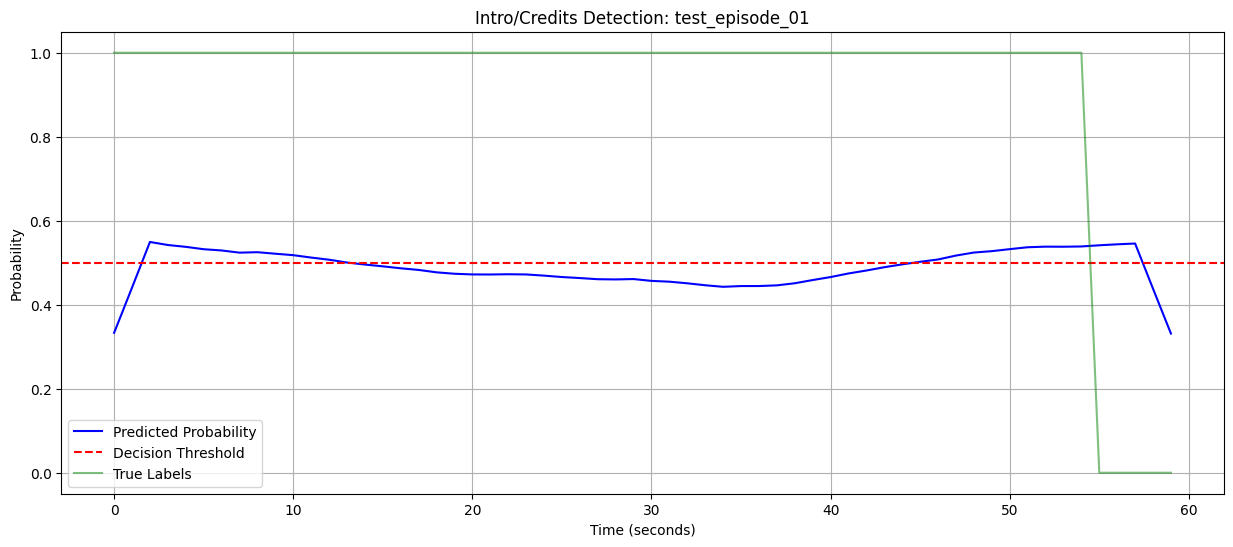

In [18]:
def plot_predictions(episode_features, true_labels, episode_name=""):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(episode_features).unsqueeze(0).to(device)
        outputs = model(inputs)
        probs = torch.sigmoid(outputs).cpu().numpy().flatten()

    # Постобработка: медианный фильтр
    probs_smoothed = np.convolve(probs, np.ones(5)/5, mode='same')

    plt.figure(figsize=(15, 6))
    plt.plot(probs_smoothed, 'b-', label='Predicted Probability')
    plt.axhline(y=0.5, color='r', linestyle='--', label='Decision Threshold')
    plt.plot(true_labels, 'g-', alpha=0.5, label='True Labels')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Probability')
    plt.title(f'Intro/Credits Detection: {episode_name}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'detection_plot_{episode_name.replace("/", "_")}.png')
    plt.show()

# Пример визуализации (предполагая, что test_sequences и test_seq_labels определены)
try:
    # Выбираем первый эпизод из тестовой выборки
    episode_idx = 0
    episode_name = "test_episode_01"  # Замените на реальное имя эпизода

    plot_predictions(
        test_sequences[episode_idx],
        test_seq_labels[episode_idx],
        episode_name=episode_name
    )
except NameError:
    print("Ошибка: test_sequences или test_seq_labels не определены. Пропускаем визуализацию.")

### Определение таймкодов

In [19]:
def detect_timestamps(probs, threshold=0.5):
    """Определяет таймкоды начала и конца основного контента"""
    # Начало интро: первый кадр с prob > threshold
    start_intro = np.argmax(probs > threshold)

    # Конец интро: последний кадр перед основным контентом
    end_intro = start_intro
    while end_intro < len(probs) and probs[end_intro] > threshold:
        end_intro += 1

    # Начало титров: первый кадр титров в конце
    start_credits = len(probs) - np.argmax(probs[::-1] > threshold) - 1

    return {
        'start_main': end_intro + 1,  # начало контента после интро
        'end_main': start_credits     # конец контента перед титрами
    }

# Пример определения таймкодов (предполагая, что test_sequences определен)
try:
    # Выбираем первый эпизод из тестовой выборки
    episode_idx = 0
    with torch.no_grad():
        inputs = torch.tensor(test_sequences[episode_idx]).unsqueeze(0).to(device)
        outputs = model(inputs)
        probs = torch.sigmoid(outputs).cpu().numpy().flatten()

    timestamps = detect_timestamps(probs)
    print(f"Start Main: {timestamps['start_main']} sec")
    print(f"End Main: {timestamps['end_main']} sec")

    # Дополнительно: преобразуем секунды в формат HH:MM:SS
    def sec_to_time(sec):
        h = sec // 3600
        m = (sec % 3600) // 60
        s = sec % 60
        return f"{h:02d}:{m:02d}:{s:02d}"

    print(f"Start Main: {sec_to_time(timestamps['start_main'])}")
    print(f"End Main: {sec_to_time(timestamps['end_main'])}")

except NameError:
    print("Ошибка: test_sequences не определен. Пропускаем определение таймкодов.")

Start Main: 14 sec
End Main: 59 sec
Start Main: 00:00:14
End Main: 00:00:59
